In [18]:
!rm -rf models
!rm -rf utils
!rm -rf main.py
!rm -rf requirements.txt

In [19]:
!git clone https://github.com/ManjeeraJ/PyTorch-Models-Era.git
!mv PyTorch-Models-Era/models ./
!mv PyTorch-Models-Era/utils ./
!mv PyTorch-Models-Era/main.py ./
!mv PyTorch-Models-Era/requirements.txt ./
!rm -rf PyTorch-Models-Era

Cloning into 'PyTorch-Models-Era'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (36/36), done.
Receiving objects: 100% (53/53), 12.14 KiB | 12.14 MiB/s, done.
Resolving deltas: 100% (27/27), done.
remote: Total 53 (delta 27), reused 38 (delta 15), pack-reused 0


In [20]:
!pip install -r requirements.txt

In [21]:
from models.resnet import ResNet18
from utils.utils import (
    get_device,
    show_sample_images,
    show_misclassified_images,
    show_losses_and_accuracies,
    show_lr_history
)
from utils.summary import getModelSummary
from utils.transforms import Transforms
from utils.dataloader import Cifar10DataLoader
import torch.optim as optim
import torch.nn as nn
from main import get_lr, train_model
from torch.optim.lr_scheduler import OneCycleLR
from utils.trainer import Trainer
from utils.tester import Tester
from utils.gradcam import show_grad_cam

In [5]:
is_cuda_available, device = get_device()
getModelSummary(ResNet18(), device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [6]:
cifar10 = Cifar10DataLoader(Transforms, 512, is_cuda_available)
train_loader = cifar10.get_loader(train=True)
test_loader = cifar10.get_loader(train=False)

Files already downloaded and verified
Files already downloaded and verified


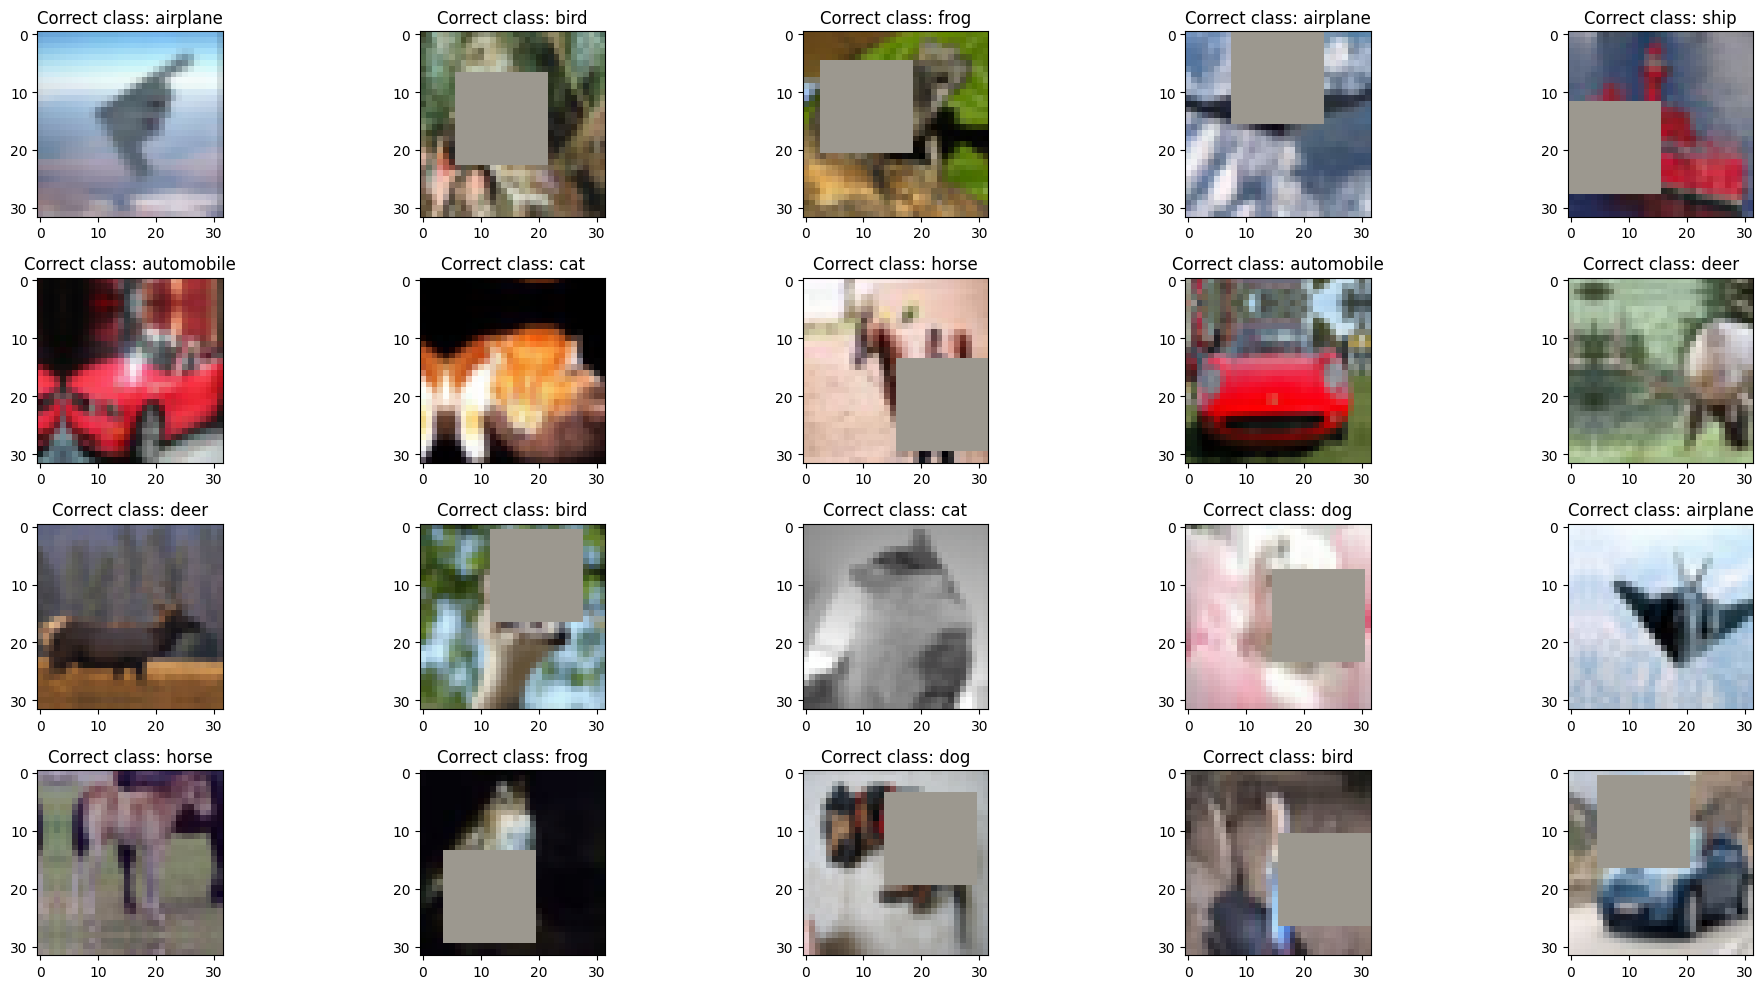

In [7]:
show_sample_images(train_loader, cifar10.classes, 20)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.10E-03


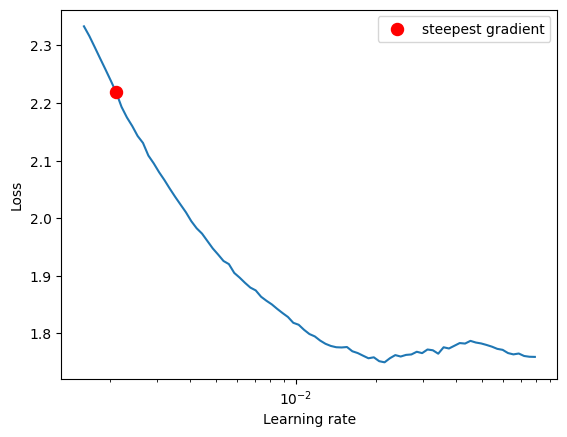

In [8]:
model = ResNet18()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)
criterion = nn.CrossEntropyLoss()

# The model parameters are reset after this finishes
get_lr(
    model,
    train_loader,
    optimizer,
    criterion,
    device,
    end_lr=0.1,
    num_iter=100,
    step_mode="exp",
)

In [9]:
num_epochs = 20

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.07,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=5 / num_epochs,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
)

trainer = Trainer(model, train_loader, optimizer, criterion, device)
tester = Tester(model, test_loader, criterion, device)

model, history = train_model(
    trainer, tester, num_epochs=num_epochs, scheduler=scheduler, save_best=False
)

EPOCH = 1 | LR = 0.014588343558282209 | Loss = 1.50 | Batch = 97 | Accuracy = 38.32: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0038, Accuracy: 3645/10000 (36.45%)


EPOCH = 2 | LR = 0.028476687116564415 | Loss = 1.27 | Batch = 97 | Accuracy = 49.78: 100%|██████████| 98/98 [00:40<00:00,  2.39it/s]


Test set: Average loss: 0.0045, Accuracy: 4144/10000 (41.44%)


EPOCH = 3 | LR = 0.04236503067484662 | Loss = 1.10 | Batch = 97 | Accuracy = 58.86: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0026, Accuracy: 5724/10000 (57.24%)


EPOCH = 4 | LR = 0.05625337423312883 | Loss = 0.86 | Batch = 97 | Accuracy = 65.04: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0019, Accuracy: 6805/10000 (68.05%)


EPOCH = 5 | LR = 0.06995238571428572 | Loss = 0.88 | Batch = 97 | Accuracy = 69.22: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0018, Accuracy: 7168/10000 (71.68%)


EPOCH = 6 | LR = 0.06528618571428572 | Loss = 0.69 | Batch = 97 | Accuracy = 74.20: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Test set: Average loss: 0.0020, Accuracy: 7046/10000 (70.46%)


EPOCH = 7 | LR = 0.06061998571428572 | Loss = 0.61 | Batch = 97 | Accuracy = 77.13: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0014, Accuracy: 7727/10000 (77.27%)


EPOCH = 8 | LR = 0.05595378571428572 | Loss = 0.61 | Batch = 97 | Accuracy = 79.96: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]


Test set: Average loss: 0.0019, Accuracy: 7115/10000 (71.15%)


EPOCH = 9 | LR = 0.05128758571428572 | Loss = 0.55 | Batch = 97 | Accuracy = 82.08: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0010, Accuracy: 8331/10000 (83.31%)


EPOCH = 10 | LR = 0.046621385714285715 | Loss = 0.42 | Batch = 97 | Accuracy = 83.92: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0009, Accuracy: 8478/10000 (84.78%)


EPOCH = 11 | LR = 0.04195518571428572 | Loss = 0.40 | Batch = 97 | Accuracy = 85.20: 100%|██████████| 98/98 [00:40<00:00,  2.39it/s]


Test set: Average loss: 0.0008, Accuracy: 8670/10000 (86.70%)


EPOCH = 12 | LR = 0.03728898571428572 | Loss = 0.39 | Batch = 97 | Accuracy = 86.53: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0008, Accuracy: 8703/10000 (87.03%)


EPOCH = 13 | LR = 0.03262278571428571 | Loss = 0.34 | Batch = 97 | Accuracy = 88.22: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0009, Accuracy: 8607/10000 (86.07%)


EPOCH = 14 | LR = 0.027956585714285713 | Loss = 0.27 | Batch = 97 | Accuracy = 89.26: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0007, Accuracy: 8802/10000 (88.02%)


EPOCH = 15 | LR = 0.02329038571428571 | Loss = 0.29 | Batch = 97 | Accuracy = 90.87: 100%|██████████| 98/98 [00:41<00:00,  2.39it/s]


Test set: Average loss: 0.0008, Accuracy: 8777/10000 (87.77%)


EPOCH = 16 | LR = 0.01862418571428571 | Loss = 0.23 | Batch = 97 | Accuracy = 91.78: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0007, Accuracy: 8951/10000 (89.51%)


EPOCH = 17 | LR = 0.013957985714285713 | Loss = 0.20 | Batch = 97 | Accuracy = 92.84: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0007, Accuracy: 8969/10000 (89.69%)


EPOCH = 18 | LR = 0.00929178571428571 | Loss = 0.13 | Batch = 97 | Accuracy = 94.09: 100%|██████████| 98/98 [00:40<00:00,  2.39it/s]


Test set: Average loss: 0.0006, Accuracy: 9101/10000 (91.01%)


EPOCH = 19 | LR = 0.004625585714285715 | Loss = 0.10 | Batch = 97 | Accuracy = 95.29: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0006, Accuracy: 9138/10000 (91.38%)


EPOCH = 20 | LR = -4.061428571429382e-05 | Loss = 0.10 | Batch = 97 | Accuracy = 96.38: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0006, Accuracy: 9170/10000 (91.70%)


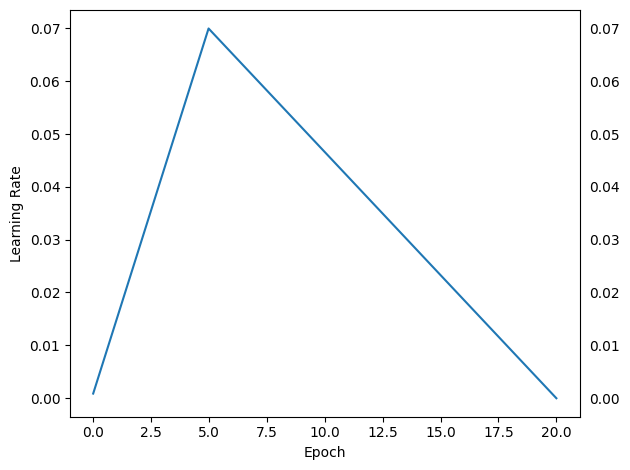

In [14]:
show_lr_history(trainer.lr_history, num_epochs)

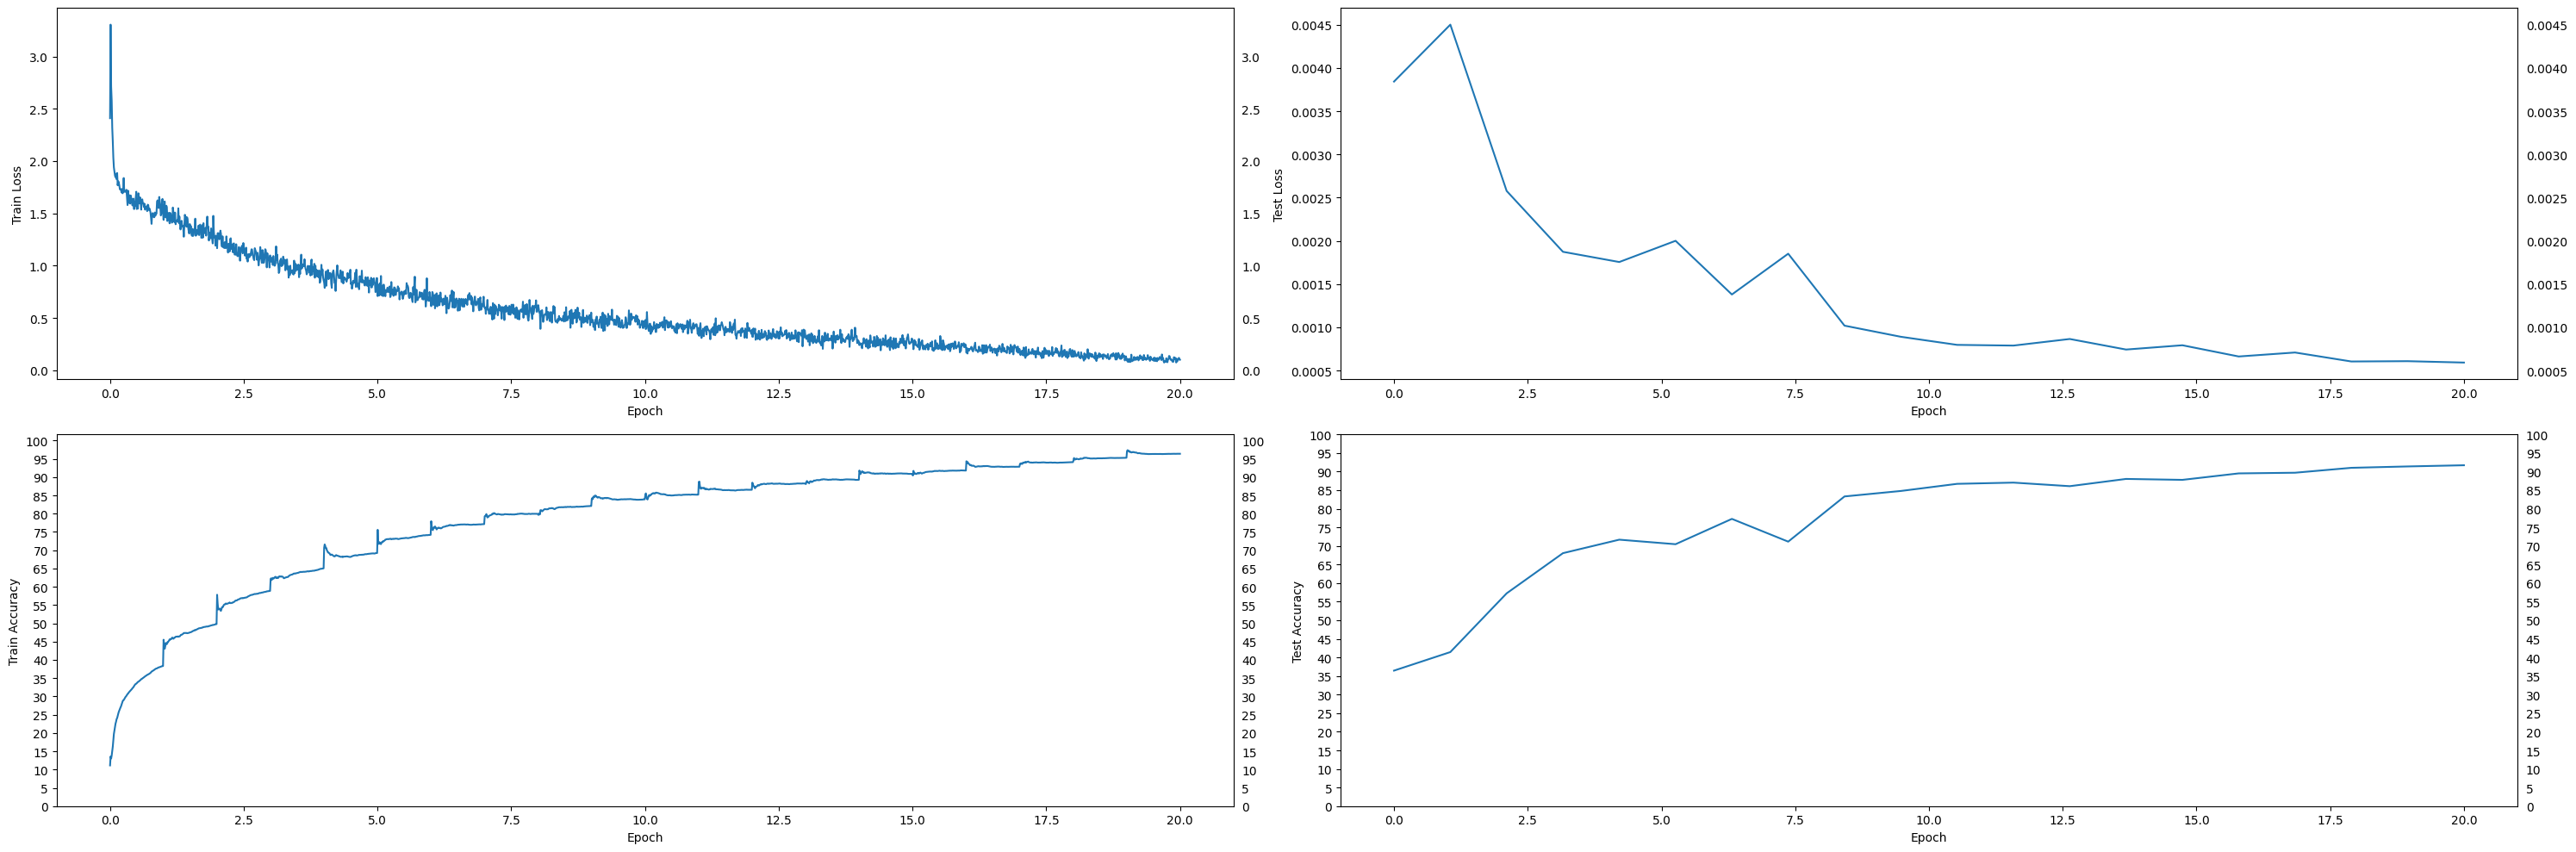

In [15]:
show_losses_and_accuracies(trainer, tester, num_epochs)

In [16]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

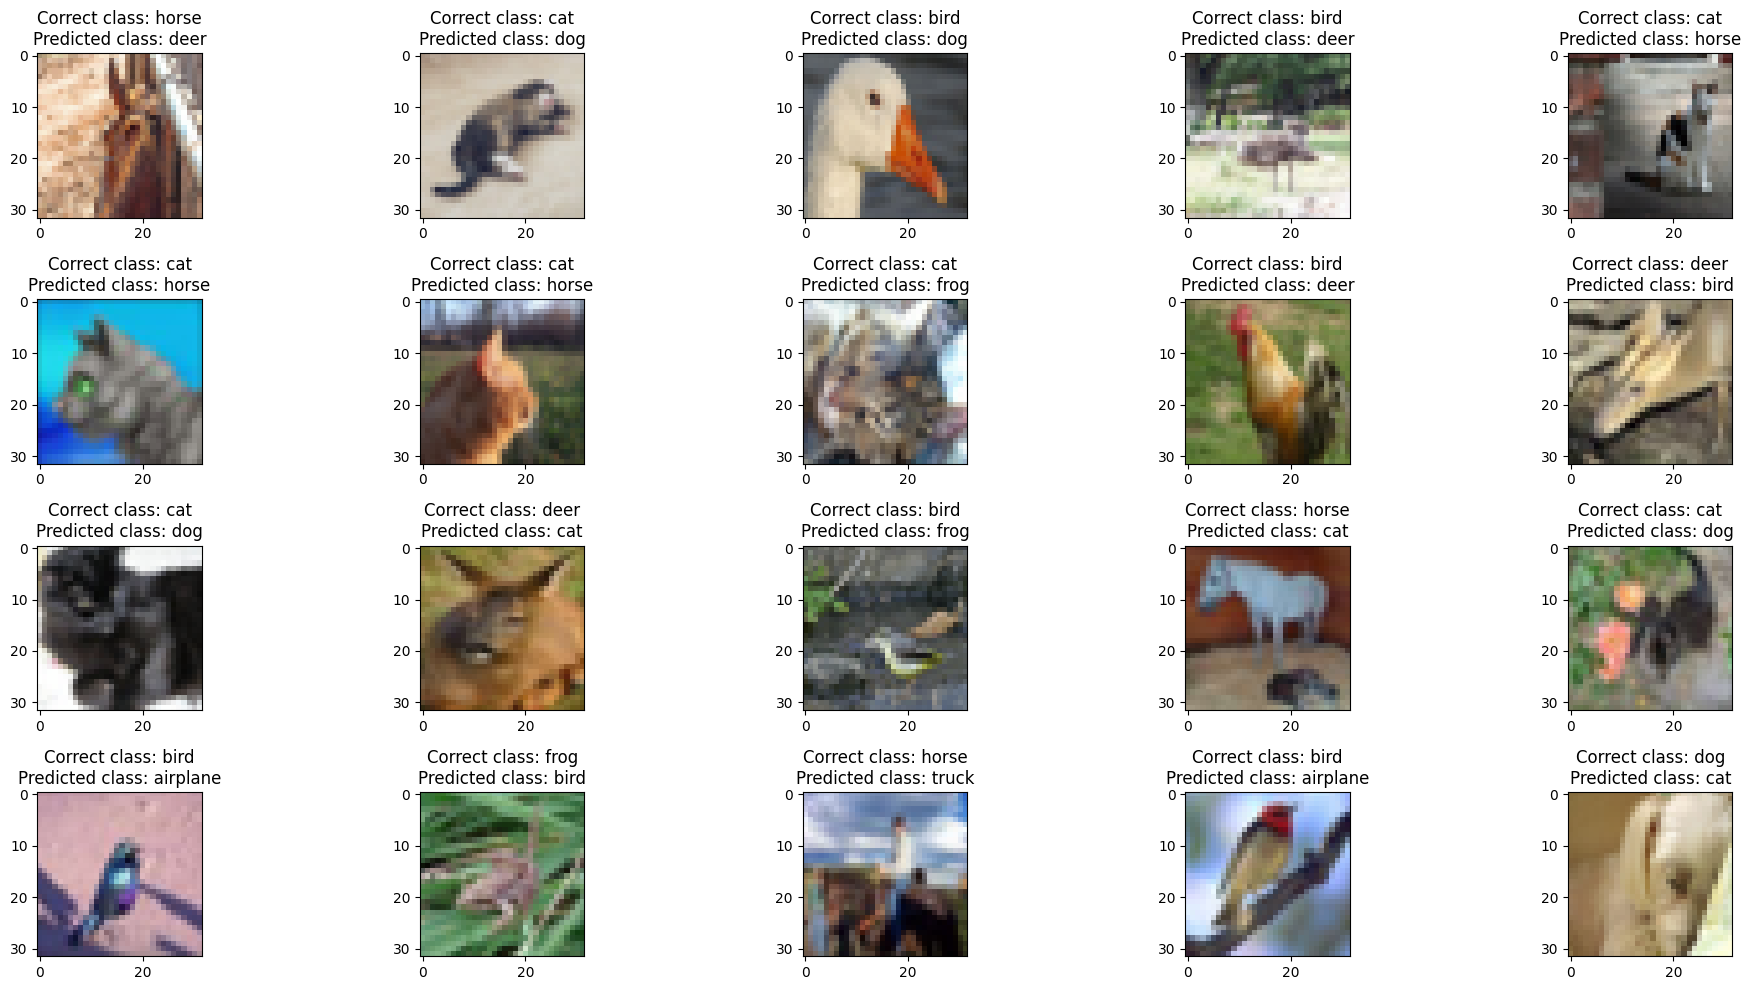

In [22]:
show_misclassified_images(
    misclassified_images[:20], predictions[:20], labels[:20], cifar10.classes
)

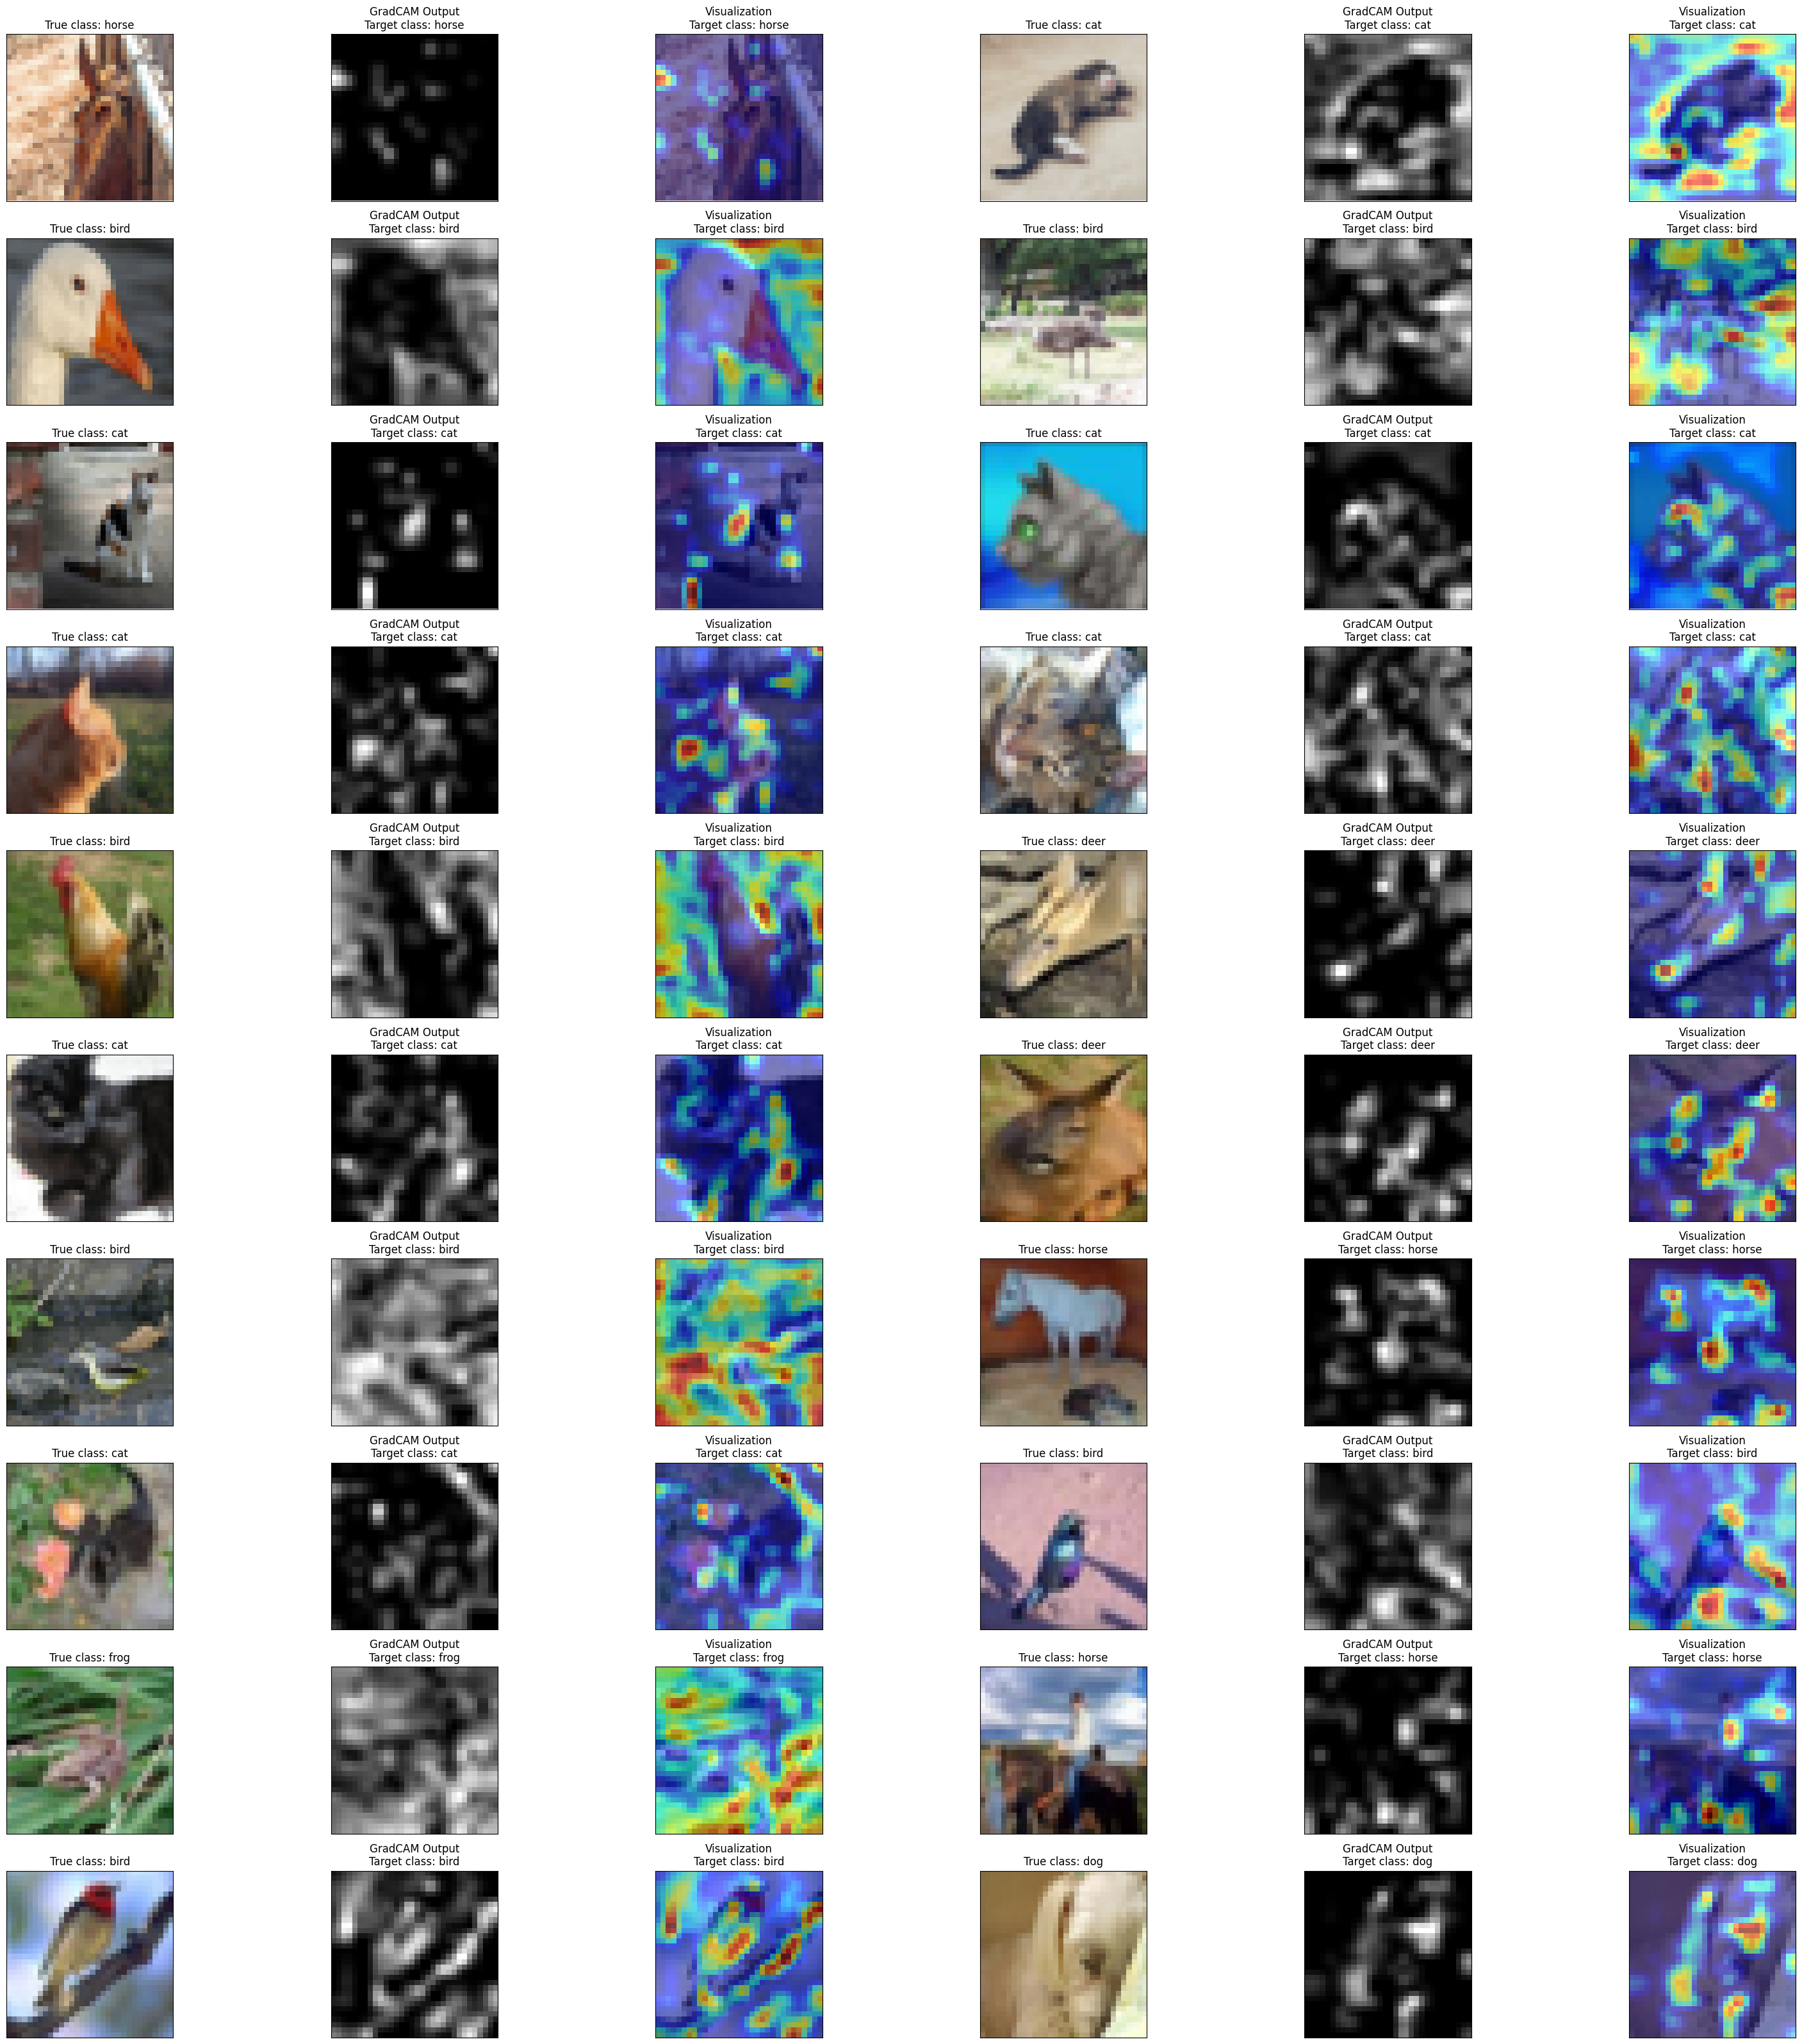

In [23]:
show_grad_cam(
    model,
    device,
    misclassified_images[:20],
    labels[:20],
    labels[:20],
    "layer2",
    cifar10.classes,
)

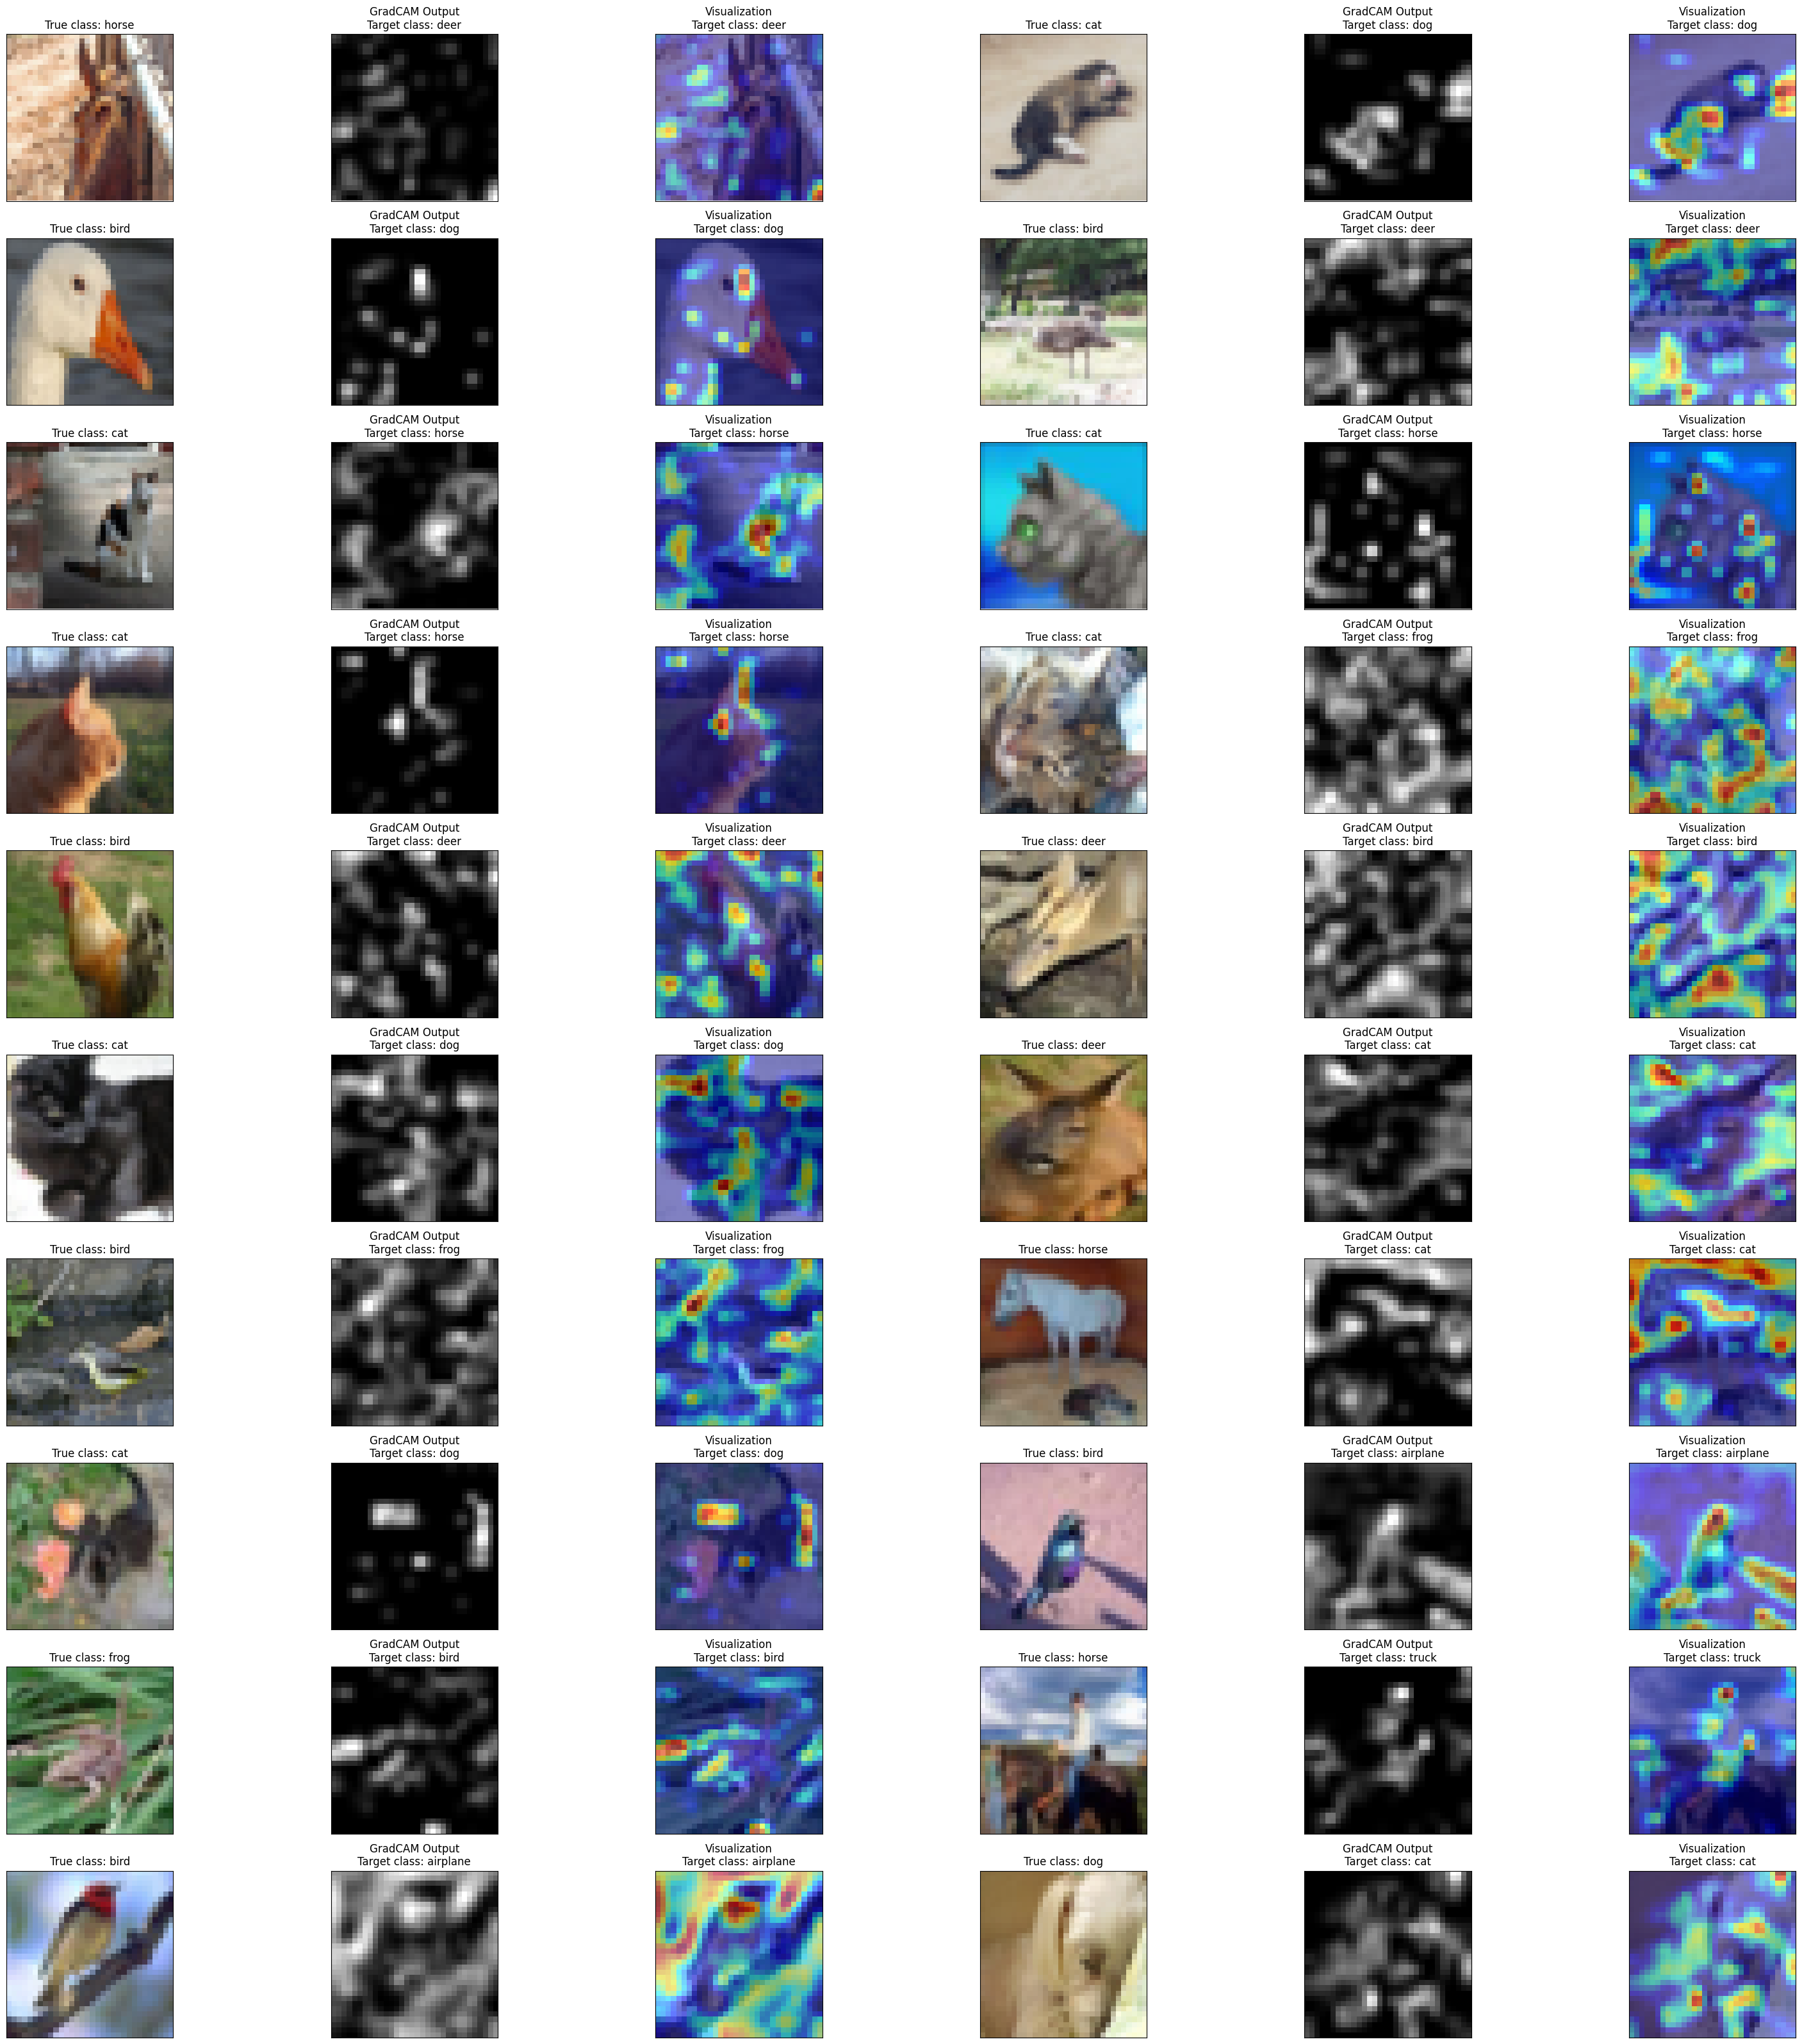

In [24]:
show_grad_cam(
    model,
    device,
    misclassified_images[:20],
    labels[:20],
    predictions[:20],
    "layer2",
    cifar10.classes,
)